# Load package

In [1]:
%cd ..

E:\Coding\Python\PlasmaChemistry


In [2]:
import os
import re
import math
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import qgrid

In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import Layout
from IPython.display import display
import ipywidgets as widgets

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["font.size"] = 15

In [5]:
from plasmistry.molecule import (H2_vib_group, CO_vib_group, CO2_vib_group)
from plasmistry.molecule import (H2_vib_energy_in_eV, H2_vib_energy_in_K,
                                 CO2_vib_energy_in_eV, CO2_vib_energy_in_K,
                                 CO_vib_energy_in_eV, CO_vib_energy_in_K)
from plasmistry.io import (LT_constructor, standard_Arr_constructor,
                           chemkin_Arr_2_rcnts_constructor,
                           chemkin_Arr_3_rcnts_constructor, eval_constructor,
                           reversed_reaction_constructor, alpha_constructor,
                           F_gamma_constructor,
                           Cros_Reaction_block, Coef_Reaction_block)
from plasmistry.reactions import (CrosReactions, CoefReactions)
from plasmistry.electron import EEDF
from plasmistry.electron import get_maxwell_eedf

In [6]:
import yaml
yaml.add_constructor("!StandardArr", standard_Arr_constructor)
yaml.add_constructor("!ChemKinArr_2_rcnt", chemkin_Arr_2_rcnts_constructor)
yaml.add_constructor("!ChemKinArr_3_rcnt", chemkin_Arr_3_rcnts_constructor)
yaml.add_constructor("!rev", reversed_reaction_constructor)
yaml.add_constructor("!LT", LT_constructor)
yaml.add_constructor("!alpha", alpha_constructor)
yaml.add_constructor("!F_gamma", F_gamma_constructor)

# variables from widgets

`_species_list`

`_init_yaml_file_path`

`_vari_dict`

`rctn_all [dict, ...]`
 - _electron reactions_
 - _relaxation reactions_
 - _chemical reactions_
 - decom_recom reactions

`rctn_df [dataframe, ...]` 
- _species_
- _electron_
- _chemical_
- decom_recom
- _relaxation_

`rctn_instances [Reactions instances, ...]`
- _cros reactions_
- _coef reactions_

In [7]:
_species_list = [
    'E', 'H2(v0-14)', 'CO2(v0-21)', 'CO(v0-10)', 'O2', 'H2O', 'H', 'O', 'OH'
]
_init_yaml_file_path = './_yaml/test_0.yaml'
_vari_dict = dict(H2_vib_energy_in_eV=H2_vib_energy_in_eV,
                  H2_vib_energy_in_K=H2_vib_energy_in_K,
                  CO2_vib_energy_in_eV=CO2_vib_energy_in_eV,
                  CO2_vib_energy_in_K=CO2_vib_energy_in_K)
# ---------------------------------------------------------------------------- #
rctn_all = {
    'global_abbr': None,
    'electron reactions': None,
    'relaxation reactions': None,
    'chemical reactions': None,
    'decom_recom reactions': None
}
with open(_init_yaml_file_path, 'r') as f:
    rctn_block = yaml.load(f)
rctn_all = rctn_block[-1]['The reactions considered']

global_abbr = rctn_all['global_abbr']

rctn_df = {
    'species': None,
    'electron': None,
    'chemical': None,
    'decom_recom': None,
    'relaxation': None
}
rctn_instances = {'cros reactions': None, 'coef reactions': None}

# widgets function
`yaml file` => `rctn_all` (dict inside)
            => `rctn_df` (dataframe insdie) 
            => `rctn_instances` (instances inside)
- `get_species_from_widgets`
- `get_rctn_df_from_widgets`
- `instance_dataframe`



In [8]:
def get_species_from_widgets(_event):
    with _widgets['output']:
        print('Get species from widgets ...', end=' ')
    species = []
    for _ in _widgets['species'].value:
        if _ == 'H2(v0-14)':
            species.append('H2')
            species.extend([f'H2(v{v})' for v in range(1, 15)])
        elif _ == 'CO2(v0-21)':
            species.append('CO2')
            species.extend([f'CO2(v{v})' for v in range(1, 22)])
        elif _ == 'CO(v0-10)':
            species.append('CO')
            species.extend([f'CO(v{v})' for v in range(11)])
        else:
            species.append(_)
    rctn_df['species'] = pd.Series(species)
    assert rctn_df['species'][0] == 'E'
    with _widgets['output']:
        print('DONE!')


def get_rctn_df_from_widgets(_event):
    with _widgets['output']:
        print('Get reaction dataframe from widgets ...', end=' ')
    rctn_df['electron'] = pd.DataFrame(
        columns=['formula', 'type', 'threshold_eV', 'cross_section'])
    rctn_df['chemical'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['relaxation'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    rctn_df['decom_recom'] = pd.DataFrame(
        columns=['formula', 'type', 'reactant', 'product', 'kstr'])
    # ------------------------------------------------------------------------ #
    #    rctn_df that is generated from the widgets and rctn_all.
    # ------------------------------------------------------------------------ #
    #   electron
    for _ in _widgets['electron'].value:
        _df = rctn_all['electron reactions'][_]
        _cros_block = Cros_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        if _ == 'H2_ele_dis_via_b':
            factor = 1e-20
            ##TODO##
            # factor = 0.2e-21
        else:
            factor = 1
        rctn_df['electron'] = pd.concat([
            rctn_df['electron'],
            _cros_block.generate_crostn_dataframe(factor=factor)
        ],
                                        ignore_index=True,
                                        sort=False)

    # ------------------------------------------------------------------------ #
    #   relaxation
    for _ in _widgets['relaxation'].value:
        _df = rctn_all['relaxation reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['relaxation'] = pd.concat(
            [rctn_df['relaxation'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #   chemical
    for _ in _widgets['chemical'].value:
        _df = rctn_all['chemical reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['chemical'] = pd.concat(
            [rctn_df['chemical'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)

    # ------------------------------------------------------------------------ #
    #    decom_recom
    for _ in _widgets['decom_recom'].value:
        _df = rctn_all['decom_recom reactions'][_]
        _coef_block = Coef_Reaction_block(rctn_dict=_df, vari_dict=_vari_dict,
                                         global_abbr=global_abbr)
        rctn_df['decom_recom'] = pd.concat(
            [rctn_df['decom_recom'],
             _coef_block.generate_crostn_dataframe()],
            ignore_index=True,
            sort=False)
    with _widgets['output']:
        print('DONE!')


# ---------------------------------------------------------------------------- #
def rctn_all_dict_keys_to_formulas(_key):
    _formula = _key.replace('_to_', ' => ')
    _formula = _formula.replace('_', ' + ')
    return _formula


# ---------------------------------------------------------------------------- #
def from_rctn_df_to_cros_instance(_df):
    split_df = _df['formula'].str.split('\s*=>\s*', expand=True)
    reactant = split_df[0]
    product = split_df[1]
    return reactant, product


def from_rctn_df_to_coef_instance(_df):
    reactant = _df['reactant']
    product = _df['product']
    kstr = _df['kstr']
    return reactant, product, kstr


# ---------------------------------------------------------------------------- #
def instance_dataframe(_):
    with _widgets['output']:
        print("Get instance from rctn_df ...", end=' ')
    # ------------------------------------------------------------------------ #
    reactant, product = from_rctn_df_to_cros_instance(rctn_df['electron'])

    rctn_instances['cros reactions'] = CrosReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        k_str=None)
    # ------------------------------------------------------------------------ #
    reactant, product, kstr = pd.Series(), pd.Series(), pd.Series()
    for _key in ['relaxation', 'chemical', 'decom_recom']:
        _r, _p, _k = from_rctn_df_to_coef_instance(rctn_df[_key])
        reactant = pd.concat([reactant, _r], ignore_index=True, sort=False)
        product = pd.concat([product, _p], ignore_index=True, sort=False)
        kstr = pd.concat([kstr, _k], ignore_index=True, sort=False)

    rctn_instances['coef reactions'] = CoefReactions(
        species=rctn_df['species'],
        reactant=reactant,
        product=product,
        k_str=kstr)
    rctn_instances['coef reactions'].compile_k_str()
    # ------------------------------------------------------------------------ #
    with _widgets['output']:
        print('DONE!')


def clean_output(_):
    _widgets['output'].clear_output()

# Set widgets and display widgets

In [9]:
# ---------------------------------------------------------------------------- #
_widgets = dict()
# ---------------------------------------------------------------------------- #
#   Set SelectMultiple widgets
# ---------------------------------------------------------------------------- #
for _, _option, _height in [
    ('species', _species_list, '400px'),
    ('electron', rctn_all['electron reactions'].keys(), '150px'),
    ('relaxation', rctn_all['relaxation reactions'].keys(), '150px'),
    ('chemical', rctn_all['chemical reactions'].keys(), '400px'),
    ('decom_recom', rctn_all['decom_recom reactions'].keys(), '400px')
]:
    if _ in ('chemical', 'decom_recom'):
        show_option = [(rctn_all_dict_keys_to_formulas(_o), _o)
                       for _o in _option]
    else:
        show_option = _option
    _widgets[_] = widgets.SelectMultiple(options=show_option,
                                         value=list(_option),
                                         layout=Layout(height=_height,
                                                       width='300px'))

# ---------------------------------------------------------------------------- #
#   Set FloatText widgets
# ---------------------------------------------------------------------------- #
for _, _value in [('electron_density', 1.0), ('Te', 1.0), ('CO2_density', 1.0),
                  ('CO2_Tvib', 1000), ('H2_density', 1.0), ('H2_Tvib', 1000),
                  ('CO_density', 1.0), ('CO_Tvib', 1000)]:
    _widgets[_] = widgets.FloatText(value=_value, layout=Layout(width='100px'))
# ---------------------------------------------------------------------------- #
#   Set Buttons
# ---------------------------------------------------------------------------- #
_button = dict()
_button['load reactions'] = widgets.Button(description='rctn_all => rctn_df')
_button['instance rctn_df'] = widgets.Button(description='=> rctn_instances')
_button['clean output'] = widgets.Button(description='clean output')

# ---------------------------------------------------------------------------- #
_widgets['output'] = widgets.Output(layout={
    'border': '2px solid blue',
    'width': '80%'
})


# ---------------------------------------------------------------------------- #
#   Widgets display
# ---------------------------------------------------------------------------- #
def _label(_str):
    return widgets.HTML(f'<b>{_str}</b>')


widgets.Text()
display(
    widgets.HBox([
        widgets.HTML('<b>Yaml File Path</b>'),
        widgets.Text(value=_init_yaml_file_path, disabled=True)
    ],
                 layout=Layout(border='solid 2px', width='80%')))
display(
    widgets.HBox(
        [
            #1
            widgets.VBox([_label('SPECIES'), _widgets['species']]),
            #2
            widgets.VBox([
                _label('ELECTRON REACTIONS'), _widgets['electron'],
                _label('RELAXATION REACTIONS'), _widgets['relaxation']
            ]),
            #3
            widgets.VBox([_label('CHEMICAL REACTIONS'), _widgets['chemical']]),
            #4
            widgets.VBox(
                [_label('DECOM_RECOM REACTIONS'), _widgets['decom_recom']])
        ],
        layout=Layout(width='80%', border='solid 2px')))
display(
    widgets.GridBox([
        widgets.HTML('<b>electron density</b>'), _widgets['electron_density'],
        widgets.HTML('<b>Te_eV</b>'), _widgets['Te'],
        widgets.HTML('<b>CO2_density</b>'), _widgets['CO2_density'],
        widgets.HTML('<b>CO2_Tvib</b>'), _widgets['CO2_Tvib'],
        widgets.HTML('<b>H2_density</b>'), _widgets['H2_density'],
        widgets.HTML('<b>H2_Tvib'), _widgets['H2_Tvib']
    ],
                    layout=widgets.Layout(
                        grid_template_columns="repeat(4, 20%)",
                        width='80%',
                        border='solid 2px')))
display(
    widgets.VBox([
        _button['load reactions'], _button['instance rctn_df'],
        _button['clean output']
    ],
                 layout=Layout(border='solid 2px',
                               display='flex',
                               align_items='stretch',
                               width='30%')))
display(_widgets['output'])
# ---------------------------------------------------------------------------- #
#   Widgets events
# ---------------------------------------------------------------------------- #
_button['load reactions'].on_click(get_rctn_df_from_widgets)
_button['load reactions'].on_click(get_species_from_widgets)
_button['instance rctn_df'].on_click(instance_dataframe)
_button['clean output'].on_click(clean_output)

GridBox(children=(HTML(value='<b>electron density</b>'), FloatText(value=1.0, layout=Layout(width='100px')), H…

Output(layout=Layout(border='2px solid blue', width='80%'))

# Prepare rctn_instances

In [11]:
eedf = EEDF(max_energy_eV=30, grid_number=300)
rctn_instances['cros reactions'].set_rate_const_matrix(
    crostn_dataframe=rctn_df['electron'],
    electron_energy_grid=eedf.energy_point)

# Tgas function

In [12]:
# ---------------------------------------------------------------------------- #
#   sharp down
#   slow down
# ---------------------------------------------------------------------------- #
def Tgas_func_sharp_down(t, time_end, Tgas_arc):
    if t > time_end:
        return 300
    else:
        return Tgas_arc


def Tgas_func_slow_down(t, time_end, time_cold, Tgas_arc):
    if t > time_end:
        return (Tgas_arc - 300) * math.exp(-(t - time_end)**2 / 2 /
                                           (time_cold - time_end)**2) + 300
    else:
        return Tgas_arc

# electron density function

In [13]:
def electron_density_func(t, time_end, _density):
    if t > time_end:
        return 0
    else:
        return _density

# dndt functions

In [14]:
_widgets['Tgas_K_0'] = widgets.Text(description='init Tgas_K:', value='3000')
_widgets['Te_eV_0'] = widgets.Text(description='init Te_eV:', value='1.5')
_widgets['ne_0'] = widgets.Text(description='init ne', value='1e20')
_widgets['time_span'] = widgets.Text(description='Time span:',
                                     value='0, 1e-1',
                                     layout=Layout(width='200px'))
_widgets['atol'] = widgets.Text(description='atol:',
                                value='1e5',
                                layout=Layout(width='200px'))
_widgets['rtol'] = widgets.Text(description='rtol:',
                                value='1e-2',
                                layout=Layout(width='200px'))
display(_widgets['Tgas_K_0'])
display(_widgets['Te_eV_0'])
display(_widgets['ne_0'])
display(_widgets['time_span'])
display(_widgets['atol'])
display(_widgets['rtol'])

Text(value='3000', description='init Tgas_K:')

Text(value='1.5', description='init Te_eV:')

Text(value='1e20', description='init ne')

Text(value='0, 1e-1', description='Time span:', layout=Layout(width='200px'))

Text(value='1e5', description='atol:', layout=Layout(width='200px'))

Text(value='1e-2', description='rtol:', layout=Layout(width='200px'))

In [15]:
Tgas_0 = float(_widgets['Tgas_K_0'].value)
Te_eV = float(_widgets['Te_eV_0'].value)
ne_0 = float(_widgets['ne_0'].value)
print(f"Tgas: {Tgas_0: .0f} K \nTe_eV: {Te_eV: .1f} eV \nne_0: {ne_0: .2e} m-3")

Tgas:  3000 K 
Te_eV:  2.0 eV 
ne_0:  1.00e+19 m-3


In [16]:
def dndt_cros(t, density_without_e, _electron_density):
    _instance = rctn_instances['cros reactions']
    _instance.set_rate_const(eedf_normalized=normalized_eedf)
    _instance.set_rate(
        density=np.hstack([_electron_density, density_without_e]))
    return _instance.get_dn()


def dndt_coef(t, density_without_e, _electron_density, Tgas_K):
    _instance = rctn_instances['coef reactions']
    _instance.set_rate_const(Tgas_K=Tgas_K)
    _instance.set_rate(
        density=np.hstack([_electron_density, density_without_e]))
    return _instance.get_dn()


def dndt_all(t, y):
    
    _e_density = electron_density_func(t, time_end, ne_0)
    
    # _Tgas_K = Tgas_func_sharp_down(t, 1e-3, Tgas_0)
    _Tgas_K = Tgas_func_slow_down(t, time_end, time_cold, Tgas_0)
    print(f"t = {t:.6e} s    Tgas_K: {_Tgas_K:.0f} K, H2: {y[0]:.1e} CO2: {y[15]:.1e}")
    dydt = dndt_cros(t, y, _e_density) + dndt_coef(t, y, _e_density, _Tgas_K)
    return dydt[1:]


def dndt_all_with_Tgas(t, y):
    pass

In [17]:
H2_percent_seq = [
    0.99, 0.93333, 0.88889, 0.83333, 0.77778, 0.66667, 0.5, 0.33333, 0.23077,
    0.16667, 0.13043, 0.09091, 0.07407, 0.0566, 0.03, 0.01, 0
]
time_end_seq = [
    0.38564, 0.46339, 0.58923, 0.66704, 0.69614, 0.8726, 0.97919, 1.01216,
    1.05427, 1.14294, 1.06026, 1.11772, 1.13853, 1.17361, 1.26435, 1.30063,
    1.27632
]
#### ====================
# i_index = 6 for H2/CO2 = 1:1
i_index = 6
H2_percent = H2_percent_seq[i_index]
time_end = time_end_seq[i_index] * 1e-3
time_cold = time_end + 2e-2
# time_end = 1e-3

In [18]:
# ---------------------------------------------------------------------------- #
density_0 = rctn_instances['cros reactions'].get_initial_density(
    density_dict={
        'CO2': 2.4e24 * (1 - H2_percent),
        'H2': 2.4e24 * H2_percent,
        'E': ne_0,
    })
density_without_e_0 = density_0[1:]
normalized_eedf = get_maxwell_eedf(eedf.energy_point, Te_eV=Te_eV)

# Start evolution

In [19]:
sol = solve_ivp(
    dndt_all,
    [float(_.strip()) for _ in _widgets['time_span'].value.split(',')],
    density_without_e_0,
    method='BDF',
    atol=float(_widgets['atol'].value),
    rtol=float(_widgets['rtol'].value))
print("Solve Done!")

t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 1.242463e-22 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 0.000000e+00 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 

t = 3.277658e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 3.277658e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 3.949085e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 3.949085e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 4.620511e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 4.620511e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.2e+24
t = 5.291937e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 5.291937e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 5.963363e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 5.963363e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 6.634790e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 6.634790e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 7.764444e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 7.764444e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 8.894099e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 1.1e+24
t = 8.894099e-10 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 

t = 1.649499e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.2e+23
t = 1.923070e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 1.923070e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 2.196641e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 2.196641e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 2.470212e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 2.470212e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 2.929144e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 2.929144e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 3.388076e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 3.388076e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 3.847007e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 3.847007e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 4.305939e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 4.305939e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 8.1e+23
t = 5.159805e-08 s    Tgas_K: 3000 K, H2: 1.2e+24 CO2: 

t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 6.5e+23
t = 1.691365e-06 s    Tgas_K: 3000 K, H2: 8.4e+23 CO2: 

t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 4.5e+23
t = 2.895398e-06 s    Tgas_K: 3000 K, H2: 5.9e+23 CO2: 

t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.440977e-06 s    Tgas_K: 3000 K, H2: 3.7e+23 CO2: 2.7e+23
t = 4.745655e-06 s    Tgas_K: 3000 K, H2: 3.4e+23 CO2: 2.5e+23
t = 4.745655e-06 s    Tgas_K: 3000 K, H2: 3.4e+23 CO2: 

t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 1.2e+23
t = 1.279741e-05 s    Tgas_K: 3000 K, H2: 2.0e+23 CO2: 

t = 2.218411e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.218411e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.218411e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.218411e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.570198e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.570198e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.570198e-05 s    Tgas_K: 3000 K, H2: 2.1e+23 CO2: 1.2e+23
t = 2.921985e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.2e+23
t = 2.921985e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.2e+23
t = 2.921985e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.2e+23
t = 2.921985e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.2e+23
t = 3.297626e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.1e+23
t = 3.297626e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.1e+23
t = 3.297626e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.1e+23
t = 3.297626e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 1.1e+23
t = 3.297626e-05 s    Tgas_K: 3000 K, H2: 2.2e+23 CO2: 

t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 1.1e+23
t = 5.072011e-05 s    Tgas_K: 3000 K, H2: 2.4e+23 CO2: 

t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 9.3e+22
t = 1.342394e-04 s    Tgas_K: 3000 K, H2: 2.7e+23 CO2: 

t = 3.366217e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 3.366217e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 3.820240e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 3.820240e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 4.274263e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 4.274263e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 5.364090e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 5.364090e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 6.453916e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 6.453916e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 7.543742e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 7.543742e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.502991e-03 s    Tgas_K: 2999 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.502991e-03 s    Tgas_K: 2999 K, H2: 2.7e+23 CO2: 9.4e+22
t = 1.502991e-03 s    Tgas_K: 2999 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.502991e-03 s    Tgas_K: 2999 K, H2: 2.9e+23 CO2: 

t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.128682e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 

t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 1.072536e-03 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 

t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.7e+22
t = 9.792223e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 

t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 8.8e+22
t = 9.824926e-04 s    Tgas_K: 3000 K, H2: 2.9e+23 CO2: 

t = 1.623924e-03 s    Tgas_K: 2999 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.623924e-03 s    Tgas_K: 2999 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.805793e-03 s    Tgas_K: 2998 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.805793e-03 s    Tgas_K: 2998 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.805793e-03 s    Tgas_K: 2998 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.987663e-03 s    Tgas_K: 2997 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.987663e-03 s    Tgas_K: 2997 K, H2: 2.7e+23 CO2: 9.7e+22
t = 1.987663e-03 s    Tgas_K: 2997 K, H2: 2.7e+23 CO2: 9.7e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 9.8e+22
t = 3.028312e-03 s    Tgas_K: 2986 K, H2: 2.6e+23 CO2: 

t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 1.2e+23
t = 8.954360e-03 s    Tgas_K: 2794 K, H2: 2.3e+23 CO2: 

t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 1.4e+23
t = 1.255595e-02 s    Tgas_K: 2584 K, H2: 2.1e+23 CO2: 

t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 1.5e+23
t = 1.496215e-02 s    Tgas_K: 2415 K, H2: 2.1e+23 CO2: 

t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.721631e-02 s    Tgas_K: 2242 K, H2: 2.1e+23 CO2: 

t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 1.7e+23
t = 1.890739e-02 s    Tgas_K: 2107 K, H2: 2.1e+23 CO2: 

t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 2.2e+23
t = 2.465072e-02 s    Tgas_K: 1640 K, H2: 2.4e+23 CO2: 

t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.719112e-02 s    Tgas_K: 1444 K, H2: 2.6e+23 CO2: 2.4e+23
t = 2.777646e-02 s    Tgas_K: 1400 K, H2: 2.7e+23 CO2: 2.5e+23
t = 2.777646e-02 s    Tgas_K: 1400 K, H2: 2.7e+23 CO2: 2.5e+23
t = 2.777646e-02 s    Tgas_K: 1400 K, H2: 2.7e+23 CO2: 2.5e+23
t = 2.836181e-02 s    Tgas_K: 1358 K, H2: 2.7e+23 CO2: 2.5e+23
t = 2.836181e-02 s    Tgas_K: 1358 K, H2: 2.7e+23 CO2: 2.5e+23
t = 2.836181e-02 s    Tgas_K: 1358 K, H2: 2.7e+23 CO2: 

t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 2.7e+23
t = 3.070319e-02 s    Tgas_K: 1195 K, H2: 2.8e+23 CO2: 

t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.554368e-02 s    Tgas_K: 906 K, H2: 2.9e+23 CO2: 2.8e+23
t = 3.55

t = 3.843031e-02 s    Tgas_K: 768 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.843031e-02 s    Tgas_K: 768 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.888163e-02 s    Tgas_K: 748 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.888163e-02 s    Tgas_K: 748 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.933295e-02 s    Tgas_K: 729 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.933295e-02 s    Tgas_K: 729 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.933295e-02 s    Tgas_K: 729 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.978426e-02 s    Tgas_K: 711 K, H2: 2.9e+23 CO2: 2.9e+23
t = 3.978426e-02 s    Tgas_K: 711 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.023558e-02 s    Tgas_K: 693 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.02

t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.302837e-02 s    Tgas_K: 596 K, H2: 2.9e+23 CO2: 2.9e+23
t = 4.30

t = 5.097120e-02 s    Tgas_K: 419 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.145822e-02 s    Tgas_K: 412 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.145822e-02 s    Tgas_K: 412 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.145822e-02 s    Tgas_K: 412 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.194525e-02 s    Tgas_K: 405 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.194525e-02 s    Tgas_K: 405 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.194525e-02 s    Tgas_K: 405 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.194525e-02 s    Tgas_K: 405 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.243227e-02 s    Tgas_K: 399 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.243227e-02 s    Tgas_K: 399 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.243227e-02 s    Tgas_K: 399 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.307881e-02 s    Tgas_K: 391 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.307881e-02 s    Tgas_K: 391 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.307881e-02 s    Tgas_K: 391 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.307881e-02 s    Tgas_K: 391 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.307881e-02 s    Tgas_K: 391 K, H2: 2.9e+23 CO2: 2.9e+23
t = 5.30

t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.171616e-02 s    Tgas_K: 327 K, H2: 2.9e+23 CO2: 2.9e+23
t = 6.17

t = 9.093636e-02 s    Tgas_K: 300 K, H2: 2.9e+23 CO2: 2.9e+23
t = 9.579459e-02 s    Tgas_K: 300 K, H2: 2.9e+23 CO2: 2.9e+23
t = 9.579459e-02 s    Tgas_K: 300 K, H2: 2.9e+23 CO2: 2.9e+23
t = 1.000000e-01 s    Tgas_K: 300 K, H2: 2.9e+23 CO2: 2.9e+23
t = 1.000000e-01 s    Tgas_K: 300 K, H2: 2.9e+23 CO2: 2.9e+23
Solve Done!


# Plot results

fig, ax = plt.subplots()
_Tgas = [Tgas_func_slow_down(_, 1e-3, 2e-3, Tgas_0) for _ in sol.t]
_e_density = [electron_density_func(_, 1e-3, ne_0) for _ in sol.t]
ax.semilogx(sol.t, _Tgas, marker='.')
ax_right = ax.twinx()
ax_right.plot(sol.t, _e_density, marker='.', color='red')

In [20]:
%matplotlib notebook
_CO2_group = ['CO2'] + [f"CO2(v{_})" for _ in range(1, 22)]
_H2_group = ['H2'] + [f"H2(v{_})" for _ in range(1, 15)]
density_result = np.vstack(
    [[electron_density_func(_, time_end, ne_0) for _ in sol.t], sol.y])
density_result_df = pd.DataFrame(
    density_result, index=rctn_instances['cros reactions'].species)
densities = dict()

<IPython.core.display.Javascript object>


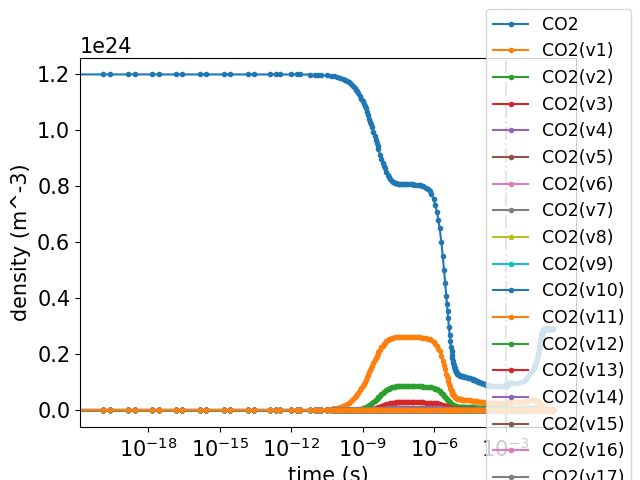

In [21]:
# ---------------------------------------------------------------------------- #
#   Plot CO2 vdf
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
for _ in ['CO2'] + [f"CO2(v{_})" for _ in range(1,22)]:
    # for _ in ['CO2_total', 'CO', 'O2', 'O']:
    if _ == 'CO2_total':
        densities[_] = density_result_df.loc[_CO2_group, :].sum().values
    elif _ == 'H2_total':
        densities[_] = density_result_df.loc[_H2_group, :].sum().values
    else:
        densities[_] = density_result[rctn_instances['cros reactions'].species
                                      == _].transpose()
    ax.semilogx(sol.t, densities[_], marker='.', label=_)
    # ax.loglog(sol.t, densities[_], marker='.', label=_)
ax.axvline(time_end, color='gray', linestyle='-.')
ax.set_xlabel('time (s)')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right', fontsize='small')

## reaction info

In [22]:
print(H2_percent)
print("H O OH")
print(
    f"{density_result_df.loc['H'].max():.1e} {density_result_df.loc['O'].max():.1e} {density_result_df.loc['OH'].max():.1e}"
)
print(f"CO output: {density_result_df.loc['CO'].values[-1]:.1e}")

0.5
H O OH
1.8e+23 5.8e+22 1.7e+23
CO output: 9.1e+23


In [23]:
density_result_df.loc['CO'].values[-1]

9.0874223386226e+23

C:\Users\PhyMan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


<IPython.core.display.Javascript object>


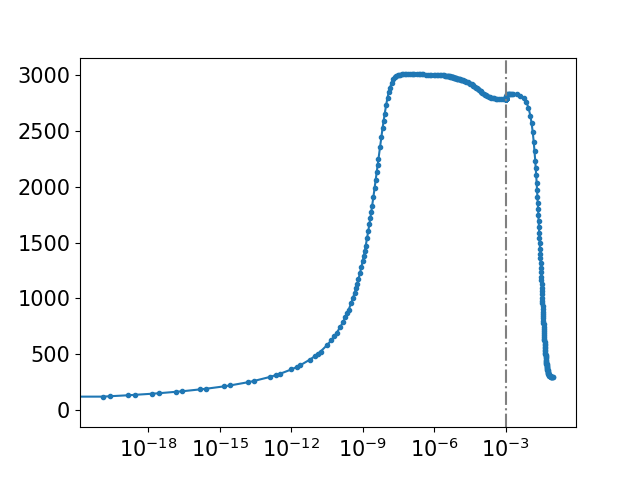

In [24]:
Tv_CO2 = -3380 / np.log(
    density_result_df.loc['CO2(v1)', :] / density_result_df.loc['CO2', :])
fig, ax = plt.subplots()
ax.semilogx(sol.t, Tv_CO2, marker='.')
ax.axvline(time_end, color='gray', linestyle='-.')

## show vdf

Output(layout=Layout(border='2px solid blue', height='350px', width='80%'))

FloatLogSlider(value=1.2424634314834948e-20, description='Time (s):', max=-1.0, min=-19.905716384678044, step=…

<IPython.core.display.Javascript object>


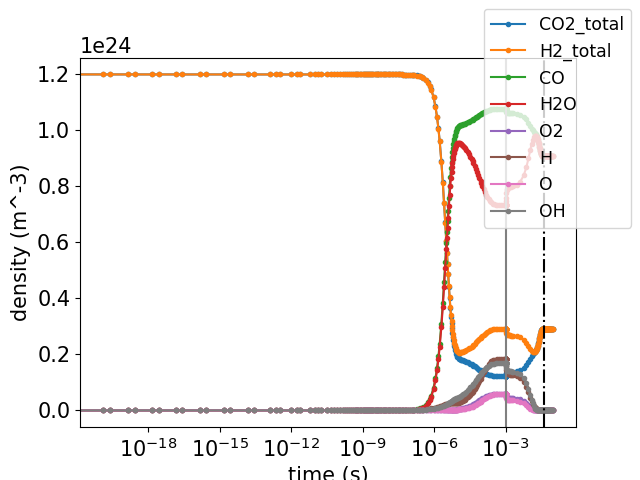

<IPython.core.display.Javascript object>


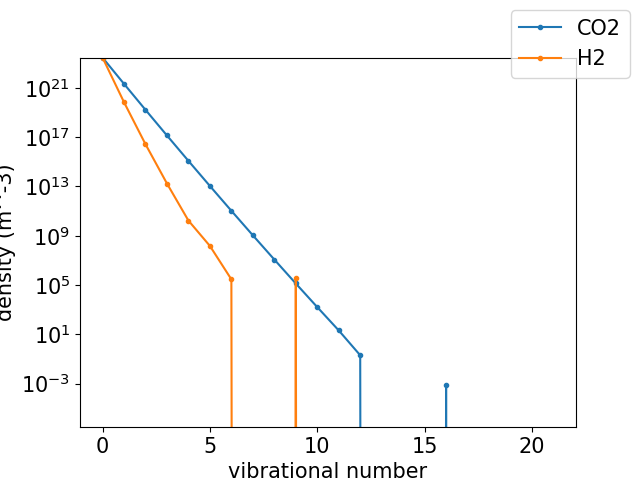

In [38]:
# _widgets['plot_vdf'] = widgets.FloatLogSlider(value=sol.t[1], min=sol.t[1], max=sol.t[-1],step=1)
_widgets['plot_vdf'] = widgets.FloatLogSlider(value=math.log10(sol.t[1]),
                                              min=math.log10(sol.t[1]),
                                              max=math.log10(sol.t[-1]),
                                              step=0.0001,
                                              description='Time (s):')

_widgets['output_rctn'] = widgets.Output(layout={
    'border': '2px solid blue',
    'width': '80%',
    'height': '350px'
})

display(_widgets['output_rctn'])
display(_widgets['plot_vdf'])
_df_show_vdf = pd.Series(index=rctn_instances['cros reactions'].species)

_interp_result = interp1d(sol.t, density_result)


def get_CO2_vdf_at_time(_t):
    return pd.Series(
        _interp_result(_t),
        index=rctn_instances['cros reactions'].species)[_CO2_group].values


def get_H2_vdf_at_time(_t):
    return pd.Series(
        _interp_result(_t),
        index=rctn_instances['cros reactions'].species)[_H2_group].values

# ---------------------------------------------------------------------------- #
#   plot main molecule
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
output_evolution = [sol.t]
for _ in ['CO2_total', 'H2_total', 'CO', 'H2O', 'O2', 'H', 'O', 'OH']:
    # for _ in ['CO2_total', 'CO', 'O2', 'O']:
    if _ == 'CO2_total':
        densities[_] = density_result_df.loc[_CO2_group, :].sum().values
    elif _ == 'H2_total':
        densities[_] = density_result_df.loc[_H2_group, :].sum().values
    else:
        densities[_] = density_result[rctn_instances['cros reactions'].species
                                      == _][0]
    line_species, = ax.semilogx(sol.t, densities[_], marker='.', label=_)
    output_evolution.append(densities[_])
    # ax.loglog(sol.t, densities[_], marker='.', label=_)
vline_time_end = ax.axvline(time_end, color='gray', linestyle='-')
vline = ax.axvline(time_end, color='black', linestyle='-.')
ax.set_xlabel('time (s)')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right', fontsize='small')
# ---------------------------------------------------------------------------- #
#   plot the vdf
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots()
line_CO2_vdf, = ax.semilogy(list(range(22)), get_CO2_vdf_at_time(0), marker='.',label='CO2')
line_H2_vdf, = ax.semilogy(list(range(15)), get_H2_vdf_at_time(0), marker='.', label='H2')
# ax.set_title('CO2 density vs. v')
ax.set_xlabel('vibrational number')
ax.set_ylabel('density (m^-3)')
fig.legend(loc='upper right')
# ax.set_title('H2 density vs. v')
# ax.set_xlabel('H2_vdf')
# ax.set_ylabel('density')


def plot_CO2_vdf(change):
    _t = change['new']
    _ydata = get_CO2_vdf_at_time(_t)
    line_CO2_vdf.set_ydata(_ydata)
    ax.set_ylim(_ydata.max()*1e-30, _ydata.max())


def plot_H2_vdf(change):
    _t = change['new']
    line_H2_vdf.set_ydata(get_H2_vdf_at_time(_t))

def regexp_match(_str):
    rcnt, prdt = _str.split('=>')
    if rcnt.count('CO2') > prdt.count('CO2'):
        return True
    else:
        return False
    
    
def show_top_reactions(change):
    # _formula_regexp = "(.*\s+)?O\s+.*=>.*"
    _t = change['new']
    _Tgas = Tgas_func_slow_down(_t, time_end, time_cold, Tgas_0)
    rctn_instances['coef reactions'].set_rate_const(Tgas_K=_Tgas)
    rctn_instances['coef reactions'].set_rate(density=_interp_result(_t))
    rctn_instances['cros reactions'].set_rate(density=_interp_result(_t))
    _df_coef = rctn_instances['coef reactions'].view_rate_const_and_rate()
    _df_coef = _df_coef[_df_coef['formula'].map(regexp_match)]
    # _df = _df[_df['formula'].str.match(_formula_regexp)]
    _df_cros = rctn_instances['cros reactions'].view_rate_const_and_rate()
    _df_cros = _df_cros[_df_cros['formula'].map(regexp_match)]
    _df = pd.concat([_df_cros, _df_coef], ignore_index=True)
    _df = _df.sort_values(by='rate', ascending=False)
    _widgets['output_rctn'].clear_output()
    vline.set_xdata(_t)
    with _widgets['output_rctn']:
        print(_df.head(n=20))
    
_widgets['plot_vdf'].observe(plot_CO2_vdf, names='value')
_widgets['plot_vdf'].observe(plot_H2_vdf, names='value')
_widgets['plot_vdf'].observe(show_top_reactions, names='value')

In [43]:
np.savetxt('output_evolution.dat', np.array(output_evolution).transpose())

In [52]:
np.savetxt('output_CO2_vdf.dat', np.array(line_CO2_vdf.get_data()).transpose())
np.savetxt('output_H2_vdf.dat', np.array(line_H2_vdf.get_data()).transpose())

In [47]:
np.array(line_CO2_vdf.get_data()).transpose()

array([[0.00000000e+00, 1.19987428e+24],
       [1.00000000e+00, 1.25622068e+20],
       [2.00000000e+00, 6.02395253e+16],
       [3.00000000e+00, 2.82417534e+16],
       [4.00000000e+00, 7.97370525e+12],
       [5.00000000e+00, 3.25482819e+09],
       [6.00000000e+00, 3.45641353e+08],
       [7.00000000e+00, 2.07790642e+05],
       [8.00000000e+00, 1.22484431e+02],
       [9.00000000e+00, 3.67597626e+00],
       [1.00000000e+01, 4.00611328e-03],
       [1.10000000e+01, 3.57870762e-06],
       [1.20000000e+01, 3.90821096e-08],
       [1.30000000e+01, 6.71779872e-11],
       [1.40000000e+01, 8.75422113e-14],
       [1.50000000e+01, 4.58392838e-16],
       [1.60000000e+01, 1.07791058e-18],
       [1.70000000e+01, 1.93044921e-21],
       [1.80000000e+01, 6.54494508e-24],
       [1.90000000e+01, 1.80914744e-26],
       [2.00000000e+01, 4.14641466e-29],
       [2.10000000e+01, 1.19560302e-31]])

In [ ]:
# ---------------------------------------------------------------------------- #
#   choose the time
# ---------------------------------------------------------------------------- #
t_chosen = 0.9e-3
# ---------------------------------------------------------------------------- #
_t_index_chosen = np.argmin(np.abs(sol.t - t_chosen))
rctn_instances['cros reactions'].set_rate(
    density=density_result[:, _t_index_chosen])
_df = rctn_instances['cros reactions'].view_rate_const_and_rate().sort_values(
    by='rate', ascending=False)


def _match(x):
    if re.match('.*H2.*=>.*H [+] H|.*CO2.*=>.*CO [+] O', x):
        return True
    else:
        return False


_df.loc[_df['formula'].map(_match)]

In [ ]:
rctn_instances['coef reactions'].set_rate_const(Tgas_K=3000,
                                                EN_Td=1.0,
                                                Te_eV=Te_eV)
rctn_instances['coef reactions'].set_rate(
    density=density_result[:, _t_index_chosen])
_df = rctn_instances['coef reactions'].view_rate_const_and_rate().sort_values(
    by='rate_const', ascending=False)


def _match(x):
    if re.match('H.*[+]\s*H\s*=>.*', x):
        return True
    else:
        return False


_df.loc[_df['formula'].map(_match)]

In [ ]:
rctn_instances['coef reactions'].mid_variables

## Species info

In [ ]:
print(f"H2 percent: {H2_percent}")
print(f"time end:{time_end}")
# print(f"O:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['O', 'density']:.2e}")
# print(f"H:  {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['H', 'density']:.2e}")
# print(f"OH: {rctn_instances['electron reactions'].view_density(sol.y[:,-1]).loc['OH', 'density']:.2e}")
##########
# max density
print('H  O  OH  CO Tvib(CO2) Tvib(H2)')
print(f"{sol.y[rctn_instances['electron reactions'].species=='H'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='O'].max(): .2e}",
      end=' ')
print(f"{sol.y[rctn_instances['electron reactions'].species=='OH'].max():.2e}",
      end=' ')
_df = rctn_instances['electron reactions'].view_density(sol.y[:, -1])
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"{Tv_CO2:.0f}", end=' ')
print(f"{Tv_H2:.0f}", end=' ')

In [ ]:
sol.y[rctn_instances['electron reactions'].species == 'H'].max()

In [ ]:
# plot CO2 vdf

x = ['CO2'] + [f'CO2(v{v})' for v in range(1, 22)]
y = [_df.loc[_, 'density'] for _ in x]
plt.semilogy(range(22), y, marker='.')

In [ ]:
Tv_CO2 = -3380 / np.log(
    _df.loc['CO2(v1)', 'density'] / _df.loc['CO2', 'density'])
Tv_H2 = -5983 / np.log(_df.loc['H2(v1)', 'density'] / _df.loc['H2', 'density'])
print(f"Tvib(CO2): {Tv_CO2:.0f} K")
print(f"Tvib(H2): {Tv_H2:.0f} K")